In [5]:
# KFJ14MAY2022; practice Keras DNN
# BRUFRA16MAY2022; practice Keras DNN, scikit-learn BDT
import numpy as np
from numpy import loadtxt
from matplotlib import pyplot as plt
import tensorflow
from keras.models import  Sequential
#from keras.models import Sequential  <<== errors
from keras.layers import Dense, Dropout
#from keras.layers import Dense   <<== gave errors
from sklearn.metrics import roc_curve, auc, mean_squared_error  ## To show results
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

EPOCHS=500
LOQUACIOUS=0
model_file = 'ANN_model.h5'
##Call functions implementation to monitor the chosen metrics
checkpoint = ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             mode='min',
                                             save_best_only = True)

#Stop training when a monitored metric has stopped improving
early_stop = EarlyStopping(monitor = 'val_loss',
                                           mode='min',# quantity that has to be monitored(to be minimized in this case)
                              patience = 50, # Number of epochs with no improvement after which training will be stopped.
                              min_delta = 1e-7,
                              restore_best_weights = True) # update the model with the best-seen weights

#Reduce learning rate when a metric has stopped improving
reduce_LR = ReduceLROnPlateau( monitor = 'val_loss',
                                              mode='min',# quantity that has to be monitored
                                              min_delta=1e-7,
                                              factor = 0.1, # factor by which LR has to be reduced...
                                              patience = 10, #...after waiting this number of epochs with no improvements 
                                              #on monitored quantity
                                              min_lr= 0.00001 ) 


callback_list = [reduce_LR, early_stop, checkpoint]

dat = loadtxt('NormDat_train.txt', delimiter=' ')
y = dat[:,0]
x = dat[:, 1:24]

## Load test data into arrays.
test = loadtxt('NormDat_test.txt', delimiter=' ')
ytst = test[:,0]
xtst = test[:, 1:24]



In [6]:
## Set up classifier structure
cl1 = Sequential()  ## type of classifier
cl1.add(Dense( 100,  activation='selu'))    ## First hidden layer # of nodes; densely connected
cl1.add(Dropout(rate=0.1))
cl1.add(Dense(  37,  activation='selu'))    ## 2nd layer
cl1.add(Dropout(rate=0.1))
cl1.add(Dense(   7,  activation='selu'))
cl1.add(Dense(   1,  activation='sigmoid')) ## Output layer uses sigmoid for classification


## Set up classifier structure
cl = Sequential()  ## type of classifier
cl.add(Dense( 100,  activation='relu'))    ## First hidden layer # of nodes; densely connected
cl.add(Dropout(rate=0.1))
cl.add(Dense(  37,  activation='relu'))    ## 2nd layer
cl.add(Dropout(rate=0.1))
cl.add(Dense(   7,  activation='relu'))
cl.add(Dense(   1,  activation='sigmoid')) ## Output layer uses sigmoid for classification

## Try out different loss functions, some better, some worse.
#cl.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )  ## <<==good

cl.compile( loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'] )   ## <<== good
cl1.compile( loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'] )   ## <<== good

#cl.compile( loss='Hinge', optimizer='adam', metrics=['accuracy'] )  ##<<== not so good


Chunk=50         # how many events per chunk
NumChuncks=100  #     .... times this determines number of training events used.
Scores_train=[]
mse_train=[]
mse_test=[]
Scores_test=[]
Scores_trainsize=[]
for iter in range(1, NumChuncks):
    TrainSize= Chunk * iter
    y_train = np.empty((TrainSize))  ## Reserve memory for trainng data...
    y_train = y[0:TrainSize]
    X_train = np.zeros((TrainSize, 23))
    for row in range(TrainSize):
        X_train[row] = x[row]
    cl.fit(X_train,y_train,epochs=EPOCHS, batch_size=256, verbose=LOQUACIOUS, validation_split=0.3) # Fitting procedure which determines the MLP weights by using a fraction TrainSize of training data
    y_score_test = cl.predict(xtst)
    y_score_train = cl.predict(X_train)
    #TrainScore = cl.score(X_train, y_train)
    #TestScore  = cl.score( xtst, ytst)
    Mse_train = mean_squared_error(y_train,y_score_train)
    Mse_test = mean_squared_error(ytst,y_score_test)
    Scores_trainsize.append(iter*1.0*Chunk)
    #Scores_train.append(TrainScore)
    #Scores_test.append(TestScore)
    mse_train.append(Mse_train)
    mse_test.append(Mse_test)
    #print("ITER: ", iter, "TrainScore: ", "%.5f" % TrainScore, "TestScore: ", "%.5f" %  TestScore  )
    


751/751 [==============================] - 1s 1ms/step - loss: 0.1602 - accuracy: 0.7906
Training Done


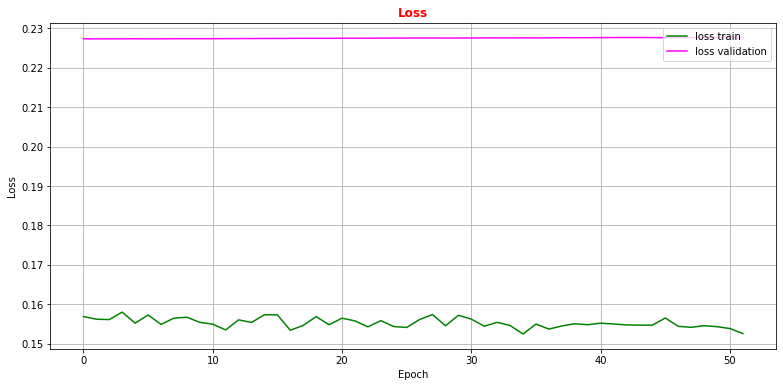

In [15]:

if EPOCHS < 100:  LOQUACIOUS=1
mlpfitted = cl.fit(x,y,epochs=EPOCHS, batch_size=128, verbose=LOQUACIOUS, validation_split=0.3, callbacks = callback_list)
cl.evaluate(x,y)
print("Training Done")
    
# plot the loss fuction vs epoch during the training phase
# the plot of the loss function on the validation set is also computed and plotted
plt.rcParams['figure.figsize'] = (13,6)
plt.plot(mlpfitted.history['loss'], label='loss train',color='green')
plt.plot(mlpfitted.history['val_loss'], label='loss validation',color='magenta')
plt.title("Loss", fontsize=12,fontweight='bold', color='r')
plt.legend(loc="upper right")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid("True")
plt.savefig("loss_vs_epocs.png", dpi=300)
plt.show()
plt.close()

#######################################################################################################
## Plotting the MLP score vs Trainsize, increasing this number in steps of Chunk number##
#######################################################################################################
# =============================================================================
# plt.plot(Scores_trainsize,Scores_train,"o-",label = "Training data set")
# plt.plot(Scores_trainsize,Scores_test,"o-",label = "Test data set")
# ## naming the x axis
# plt.xlabel('Number of training samples')
# ## naming the y axis
# plt.ylabel('MLP score')
# ## giving a title to my graph
# plt.title('Training and test score on Training and Test samples')
# ## show a legend on the plot
# plt.legend(['Training data set','Validation data set'])
# plt.savefig('numbertrainingsamples_MLP_score.png', dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()
# =============================================================================






In [25]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=700)
bdt.fit(x,y)
if EPOCHS < 100:  LOQUACIOUS=1
cl1.fit(x,y,epochs=EPOCHS, batch_size=128, verbose=LOQUACIOUS, validation_split=0.3)#, callbacks = callback_list)
cl1.evaluate(x,y)
print("Training Done")
OOB_train = np.zeros((len(x), 2))  ## Set up to collect Out-Of-Bag results
OOBResults_train = cl1.predict(x)
for i in range(len(y)):
    OOB_train[i,0] = y[i]
    OOB_train[i,1] = OOBResults_train[i]

np.savetxt('OOB_train.txt', OOB_train , fmt="%d  %.7f")  ##<<== test results are saved here!

OOB_test = np.zeros((len(ytst), 2))  ## Set up to collect Out-Of-Bag results

OOBResults_test = cl1.predict(xtst)  ## Get predictions from NN on test data.

for i in range(len(ytst)):      ## Put results into array for plotting, writing,...
    OOB_test[i,0] = ytst[i]
    OOB_test[i,1] = OOBResults_test[i]
## Preview
for i in range(20):
    print(OOBResults_test[i], ytst[i]) 
print("Testing predictions available: \n", cl1.evaluate(xtst,ytst) )
np.savetxt('OOB_test.txt', OOB_test , fmt="%d  %.7f")  ##<<== test results are saved here!



751/751 [==============================] - 1s 1ms/step - loss: 0.1466 - accuracy: 0.7994
Training Done
[0.83421624] 1.0
[0.3438771] 0.0
[0.4907951] 0.0
[0.6926871] 1.0
[0.10083932] 0.0
[0.7730754] 1.0
[0.71507716] 1.0
[0.01138958] 0.0
[0.7007451] 1.0
[0.05703104] 0.0
[0.27005035] 0.0
[0.21625084] 0.0
[0.38713533] 1.0
[0.9912913] 1.0
[0.43939114] 0.0
[0.45802376] 0.0
[0.96084464] 1.0
[0.9578624] 1.0
[0.32114363] 0.0
[0.43813044] 1.0
188/188 [==============================] - 0s 1ms/step - loss: 0.1903 - accuracy: 0.7169
Testing predictions available: 
 [0.19032815098762512, 0.7168554067611694]


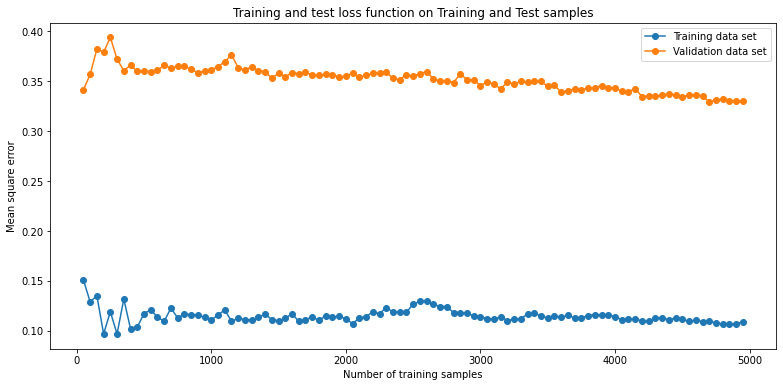

In [26]:
#############################################################################################################################
## Plotting the Mean square error loss function vs size of training sample, increasing this number in steps of Chunk number##
#############################################################################################################################
plt.clf() # clean the figure
plt.plot(Scores_trainsize,mse_train,"o-",label = "Training data set")
plt.plot(Scores_trainsize,mse_test,"o-",label = "Test data set")
## naming the x axis
plt.xlabel('Number of training samples')
## naming the y axis
plt.ylabel('Mean square error')
## giving a title to my graph
plt.title('Training and test loss function on Training and Test samples')
## show a legend on the plot
plt.legend(['Training data set','Validation data set'])
plt.savefig('numbertrainingsamples_loss_mse.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [27]:

#Plotting ROC curve
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

fpr_test_bdt = dict()
tpr_test_bdt = dict()
roc_auc_test_bdt = dict()
fpr_train_bdt = dict()
tpr_train_bdt = dict()
roc_auc_train_bdt = dict()
lw=2

fpr_test, tpr_test, _ = roc_curve(ytst, OOBResults_test)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y, OOBResults_train)
roc_auc_train = auc(fpr_train, tpr_train)

y_score_test_bdt = bdt.predict_proba(xtst) # MLP prediction on test data
y_score_training_bdt = bdt.predict_proba(x)# MLP prediction on training data

fpr_test_bdt, tpr_test_bdt, _ = roc_curve(ytst, y_score_test_bdt[:,1])
roc_auc_test_bdt = auc(fpr_test_bdt, tpr_test_bdt)
fpr_train_bdt, tpr_train_bdt, _ = roc_curve(y, y_score_training_bdt[:,1])
roc_auc_train_bdt = auc(fpr_train_bdt, tpr_train_bdt)


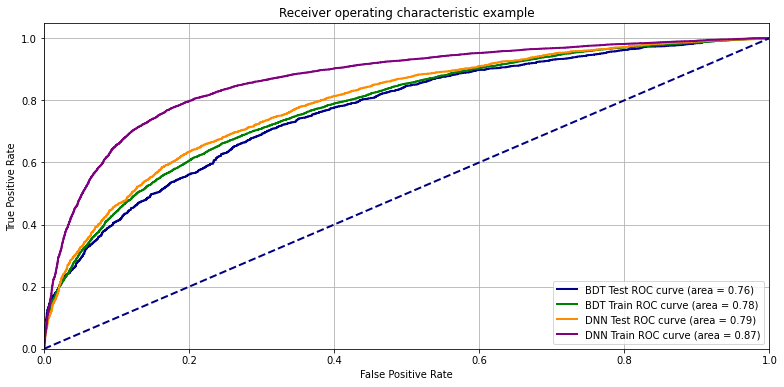

In [28]:

plt.figure()
plt.plot(fpr_test_bdt,tpr_test_bdt,color="darkblue",lw=lw,label="BDT Test ROC curve (area = %0.2f)" % roc_auc_test_bdt)
plt.plot(fpr_train_bdt,tpr_train_bdt,color="green",lw=lw,label="BDT Train ROC curve (area = %0.2f)" % roc_auc_train_bdt)
plt.plot(fpr_test,tpr_test,color="darkorange",lw=lw,label="DNN Test ROC curve (area = %0.2f)" % roc_auc_test)
plt.plot(fpr_train,tpr_train,color="purple",lw=lw,label="DNN Train ROC curve (area = %0.2f)" % roc_auc_train)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid("True")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig("ROC_curve.png", dpi=300)
plt.show()

